HW4 and Question 3,    **Mahdi Koloushani**, 401300066

In [20]:
!git clone https://github.com/amnghd/Persian_poems_corpus

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
fatal: destination path 'Persian_poems_corpus' already exists and is not an empty directory.


In [3]:
!pip install sentencepiece
!pip install transformers

In [4]:
from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import AutoModelForTokenClassification  # for pytorch
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import BertModel
import torch
from torch.utils.data import Dataset , DataLoader
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Data Preprocessing

ابتدا فایل های مربوط به اشعار ده شاعر دلخواه خوانده می شود

In [5]:
data0 = open('/kaggle/working/Persian_poems_corpus/normalized/hatef_norm.txt' , encoding='utf-8').read().strip().split('\n')
data1 = open('/kaggle/working/Persian_poems_corpus/normalized/bahar_norm.txt' , encoding='utf-8').read().strip().split('\n')
data2 = open('/kaggle/working/Persian_poems_corpus/normalized/khajoo_norm.txt' , encoding='utf-8').read().strip().split('\n')
data3 = open('/kaggle/working/Persian_poems_corpus/normalized/hafez_norm.txt' , encoding='utf-8').read().strip().split('\n')
data4 = open('/kaggle/working/Persian_poems_corpus/normalized/khayyam_norm.txt' , encoding='utf-8').read().strip().split('\n')
data5 = open('/kaggle/working/Persian_poems_corpus/normalized/saeb_norm.txt' , encoding='utf-8').read().strip().split('\n')
data6 = open('/kaggle/working/Persian_poems_corpus/normalized/saadi_norm.txt' , encoding='utf-8').read().strip().split('\n')
data7 = open('/kaggle/working/Persian_poems_corpus/normalized/shahriar_norm.txt' , encoding='utf-8').read().strip().split('\n')
data8 = open('/kaggle/working/Persian_poems_corpus/normalized/moulavi_norm.txt' , encoding='utf-8').read().strip().split('\n')
data9 = open('/kaggle/working/Persian_poems_corpus/normalized/bidel_norm.txt' , encoding='utf-8').read().strip().split('\n')
classes = ["Hatef", "Bahar", "Khajoo", "Hafez", "Khayyam", "Saeb", "Saadi", "Shahriar", "Moulavi", "Bidel"]

برخی از فایل ها دارای سطرهای خالی هستند که این سطرها حذف می شوند.

In [6]:
while("" in data0):
    data0.remove("")
while("" in data1):
    data1.remove("")
while("" in data2):
    data2.remove("")
while("" in data3):
    data3.remove("")
while("" in data4):
    data4.remove("")
while("" in data5):
    data5.remove("")
while("" in data6):
    data6.remove("")
while("" in data7):
    data7.remove("")
while("" in data8):
    data8.remove("")
while("" in data9):
    data9.remove("")

## Defining Dataset Creator Class



In [7]:
class Dataset_Creator(Dataset):

    def __init__(self, text, label, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = label*torch.ones((len(text),1))
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long),torch.tensor(token_type_ids, dtype=torch.long), torch.tensor(self.targets[index], dtype=torch.float)
      

### Load the tokenizer and creat datasets of ten different Poets




In [8]:
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
#model_name_or_path = "HooshvareLab/bert-fa-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
max_length = 15
dataset0 = Dataset_Creator(data0, 0, tokenizer, max_length)
dataset1 = Dataset_Creator(data1, 1, tokenizer, max_length)
dataset2 = Dataset_Creator(data2, 2, tokenizer, max_length)
dataset3 = Dataset_Creator(data3, 3, tokenizer, max_length)
dataset4 = Dataset_Creator(data4, 4, tokenizer, max_length)
dataset5 = Dataset_Creator(data5, 5, tokenizer, max_length)
dataset6 = Dataset_Creator(data6, 6, tokenizer, max_length)
dataset7 = Dataset_Creator(data7, 7, tokenizer, max_length)
dataset8 = Dataset_Creator(data8, 8, tokenizer, max_length)
dataset9 = Dataset_Creator(data9, 9, tokenizer, max_length)

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

### Combining the datasets and split the final dataset to train, validation and test datasets

In [9]:
datasets = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8, dataset9]
dataset = torch.utils.data.ConcatDataset(datasets)
data_len = len(dataset)
train_len = int(data_len*0.6)
valid_len = int(data_len*0.2)
test_len = data_len-train_len-valid_len
train_dataset, valid_dataset, test_dataset= torch.utils.data.random_split(dataset, [train_len, valid_len, test_len])

### Creating Dataloader 

In [10]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

### Calculation of weights for weighted cross entropy loss

In [11]:
len_data =torch.tensor([len(data0), len(data1), len(data2), len(data3), len(data4), len(data5), len(data6), len(data7), len(data8), len(data9)])
freqs = len_data/sum(len_data)
weights = sum(len_data)/(10*freqs)
weights = weights/sum(weights)
print(f"Data Length for each Class: {len_data}")
print(f"Weights = {weights}")

Data Length for each Class: tensor([ 3567, 41641, 17693,  9435,  1286, 15003, 31381,  3812, 52956, 64665])
Weights = tensor([0.1710, 0.0146, 0.0345, 0.0646, 0.4742, 0.0407, 0.0194, 0.1600, 0.0115,
        0.0094])


## Defining a Train function

In [15]:
from tqdm import tqdm
def train(train_data, valid_data, Model, Optimizer, epochs, save_path):
  best_val = 1e10
  for epoch in range(epochs):
    print(f"####  Epoch: {epoch+1}  ####")
    Model.train()
    #loss_t = 0
    for _,data in enumerate(tqdm(train_data), 0):
      ids, mask,token_type_ids, labels = data
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      # token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.long)
      labels = torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float).reshape((-1,10))

      preds = Model(ids, attention_mask = mask, labels =labels)[1]
      Optimizer.zero_grad()
      loss = loss_fn(preds, labels)
      #loss_t += loss.item()
      loss.backward()
      Optimizer.step()
    #loss_t /=len(train_data)

    loss_t = 0
    acc_t = 0 
    for _,data in enumerate(train_data, 0):
      ids, mask, token_type_ids,labels = data
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.long)
      labels = torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float).reshape((-1,10))
      preds = Model(ids, attention_mask = mask, labels = labels)[1]
      loss_t += loss_fn(preds, labels).item()
      acc_t +=torch.sum(torch.argmax(labels,dim=1) == torch.argmax(preds,dim=1))
    acc_t = acc_t/train_len
    loss_t /= len(train_data)


    #print(f'Train Loss:  {loss_t}')
    loss_val = 0
    acc_val = 0 
    for _,data in enumerate(valid_data, 0):
      ids, mask, token_type_ids,labels = data
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.long)
      labels = torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float).reshape((-1,10))
      preds = Model(ids, attention_mask = mask, labels = labels)[1]
      loss_val += loss_fn(preds, labels).item()
      acc_val +=torch.sum(torch.argmax(labels,dim=1) == torch.argmax(preds,dim=1))
    acc_val = acc_val/valid_len
    loss_val /= len(valid_data)

    if loss_val < best_val:
      best_val = loss_val
      torch.save(Model, save_path)
        
    
    print(f"Train Loss = {loss_t}  Train Accuracy = {acc_t}   Validation Loss = {loss_val}  Validation Accuracy = {acc_val}")

    # print(f"Validation Loss = {loss_val}  Validation Accuracy = {acc_val}")







### Defining a Test function

In [14]:
def test(Model , dataloader):
  Model.eval()
  fin_labels=[]
  fin_preds=[]
  with torch.no_grad():
    for _, data in enumerate(tqdm(dataloader), 0):
      ids, mask, token_type_ids, labels = data
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.long)
      labels = torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float).reshape((-1,10))
      preds = Model(ids, mask, token_type_ids, labels=labels)[1]
      fin_labels.extend(labels.argmax(dim=1).cpu().detach().numpy().tolist())
      fin_preds.extend(torch.nn.functional.softmax(preds, dim=1).argmax(dim=1).cpu().detach().numpy().tolist())
  return fin_preds, fin_labels

#Part A

مدل از قبل آموزش دیده به عنوان یک کلاسیفایر متن لود شده و تعداد کلاس ها را هم 10 قرار می دهیم. سپس دو لایه ی آخر را قابل یادگیری و سایر بخش ها را غیر قابل یادگیری قرار می دهیم. 

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels = 10, output_attentions = False, output_hidden_states = False)


for name, param in model.named_parameters():
  if 'classifier' in name: #classifier layer
    param.requires_grad = True
  elif 'pooler' in name: #bertpooler layer
    param.requires_grad = True
  else:
    param.requires_grad = False

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

# Training

In [26]:
lr = 0.0002
epochs = 20

# def loss_fn(outputs, targets):
#     return torch.nn.BCEWithLogitsLoss(weight = weights.to(device))(outputs, targets)

loss_fn = torch.nn.BCEWithLogitsLoss(weight = weights.to(device))


optimizer = torch.optim.AdamW(params = model.parameters(), lr=lr)
# loss_func = torch.nn.CrossEntropyLoss(weight = weights.to(device))

In [27]:
model = model.to(device)
save_path_p1 = "BestModel_P1.pth"
train(train_dataloader, valid_dataloader, model, optimizer, epochs, save_path_p1)

####  Epoch: 1  ####


100%|██████████| 4527/4527 [01:19<00:00, 56.70it/s]


Train Loss = 0.008860163653194525  Train Accuracy = 0.4279629588127136   Validation Loss = 0.008963745870739172  Validation Accuracy = 0.4225567877292633
####  Epoch: 2  ####


100%|██████████| 4527/4527 [01:20<00:00, 56.32it/s]


Train Loss = 0.00866845227859837  Train Accuracy = 0.4396360516548157   Validation Loss = 0.008804283912415197  Validation Accuracy = 0.4339677095413208
####  Epoch: 3  ####


100%|██████████| 4527/4527 [01:20<00:00, 56.41it/s]


Train Loss = 0.008618293361240878  Train Accuracy = 0.4411064088344574   Validation Loss = 0.008802783126202815  Validation Accuracy = 0.4348375201225281
####  Epoch: 4  ####


100%|██████████| 4527/4527 [01:20<00:00, 56.34it/s]


Train Loss = 0.008439165955709356  Train Accuracy = 0.447415828704834   Validation Loss = 0.008653523278841719  Validation Accuracy = 0.43916580080986023
####  Epoch: 5  ####


100%|██████████| 4527/4527 [01:20<00:00, 56.39it/s]


Train Loss = 0.00844239381935858  Train Accuracy = 0.44767123460769653   Validation Loss = 0.008690415188328242  Validation Accuracy = 0.44100895524024963
####  Epoch: 6  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.82it/s]


Train Loss = 0.008269521353985626  Train Accuracy = 0.4520823061466217   Validation Loss = 0.008596163738341206  Validation Accuracy = 0.4426657259464264
####  Epoch: 7  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.83it/s]


Train Loss = 0.008181165754089434  Train Accuracy = 0.45783257484436035   Validation Loss = 0.008540824586445327  Validation Accuracy = 0.4477602541446686
####  Epoch: 8  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.81it/s]


Train Loss = 0.008222229228397576  Train Accuracy = 0.45819151401519775   Validation Loss = 0.008628285410051771  Validation Accuracy = 0.4478638172149658
####  Epoch: 9  ####


100%|██████████| 4527/4527 [01:20<00:00, 55.95it/s]


Train Loss = 0.008186342516895083  Train Accuracy = 0.4623126685619354   Validation Loss = 0.00861526384096126  Validation Accuracy = 0.45109447836875916
####  Epoch: 10  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.80it/s]


Train Loss = 0.008079546922478378  Train Accuracy = 0.4622091054916382   Validation Loss = 0.008590144715336694  Validation Accuracy = 0.45318615436553955
####  Epoch: 11  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.56it/s]


Train Loss = 0.008032442431284684  Train Accuracy = 0.46587464213371277   Validation Loss = 0.008587236125040688  Validation Accuracy = 0.45256486535072327
####  Epoch: 12  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.60it/s]


Train Loss = 0.007959775241385624  Train Accuracy = 0.46812504529953003   Validation Loss = 0.008599346713456118  Validation Accuracy = 0.45536065101623535
####  Epoch: 13  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.46it/s]


Train Loss = 0.007911121029273476  Train Accuracy = 0.46933308243751526   Validation Loss = 0.008578737436548725  Validation Accuracy = 0.4573073387145996
####  Epoch: 14  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.58it/s]


Train Loss = 0.008008144536473865  Train Accuracy = 0.46801459789276123   Validation Loss = 0.008692029029170436  Validation Accuracy = 0.45360034704208374
####  Epoch: 15  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.58it/s]


Train Loss = 0.00795518625971989  Train Accuracy = 0.4695746898651123   Validation Loss = 0.00872217320372345  Validation Accuracy = 0.4563961327075958
####  Epoch: 16  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.60it/s]


Train Loss = 0.007748060928143747  Train Accuracy = 0.4707965552806854   Validation Loss = 0.008551367015267411  Validation Accuracy = 0.4592333137989044
####  Epoch: 17  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.88it/s]


Train Loss = 0.007748795752815766  Train Accuracy = 0.47291579842567444   Validation Loss = 0.008623138275626994  Validation Accuracy = 0.4579700529575348
####  Epoch: 18  ####


100%|██████████| 4527/4527 [01:20<00:00, 55.90it/s]


Train Loss = 0.007815434340377708  Train Accuracy = 0.466281920671463   Validation Loss = 0.008673573054609026  Validation Accuracy = 0.4521713852882385
####  Epoch: 19  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.69it/s]


Train Loss = 0.0076766875204767005  Train Accuracy = 0.4717077612876892   Validation Loss = 0.00861322083553661  Validation Accuracy = 0.4570173919200897
####  Epoch: 20  ####


100%|██████████| 4527/4527 [01:21<00:00, 55.81it/s]


Train Loss = 0.00767912470627809  Train Accuracy = 0.47279152274131775   Validation Loss = 0.00858488639803064  Validation Accuracy = 0.4578457772731781


### Load the best model for part A and evaluate it

In [28]:
Model_p1 = torch.load(save_path_p1)
preds , targets = test(Model_p1, test_dataloader)
preds_t = torch.tensor(preds)
targets_t = torch.tensor(targets)

100%|██████████| 1510/1510 [00:34<00:00, 43.26it/s]


Calculation of Accuracy and F1 Score metrics

In [29]:
accuracy = metrics.accuracy_score(targets_t , preds_t)
f1_score_micro = metrics.f1_score(targets_t, preds_t, average='micro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")

Accuracy Score = 0.47961233407194187
F1 Score (Micro) = 0.47961233407194187


Confusion Matrix plot

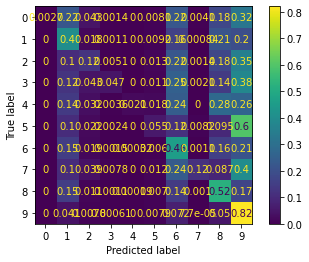

In [30]:
confusion_matrix = metrics.confusion_matrix(targets_t, preds_t)
confusion_matrix_n = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_n)

cm_display.plot()
plt.show()

#Part B

### ADAM

In [33]:
model_p2_Adam = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels = 10, output_attentions = False, output_hidden_states = False)

lr = 0.00002
epochs = 10

optimizer_Adam = torch.optim.AdamW(params = model_p2_Adam.parameters(), lr=lr)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

In [34]:
model_p2_Adam = model_p2_Adam.to(device)
save_path_p2_Adam = "BestModel_P2_Adam.pth"
train(train_dataloader, valid_dataloader, model_p2_Adam, optimizer_Adam, epochs, save_path_p2_Adam)

####  Epoch: 1  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.50it/s]


Train Loss = 0.006126333754188754  Train Accuracy = 0.6326667070388794   Validation Loss = 0.006926628997064312  Validation Accuracy = 0.603475034236908
####  Epoch: 2  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.49it/s]


Train Loss = 0.004735719931869629  Train Accuracy = 0.704651951789856   Validation Loss = 0.006447114238164939  Validation Accuracy = 0.6444798707962036
####  Epoch: 3  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.50it/s]


Train Loss = 0.003898813418917702  Train Accuracy = 0.739112138748169   Validation Loss = 0.006798902970943612  Validation Accuracy = 0.6501335501670837
####  Epoch: 4  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.49it/s]


Train Loss = 0.002842758839734159  Train Accuracy = 0.7834850549697876   Validation Loss = 0.006542617568608578  Validation Accuracy = 0.6722099184989929
####  Epoch: 5  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.50it/s]


Train Loss = 0.0023583028035438765  Train Accuracy = 0.8095372915267944   Validation Loss = 0.006890554183423199  Validation Accuracy = 0.6715679168701172
####  Epoch: 6  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.49it/s]


Train Loss = 0.0020265032628623953  Train Accuracy = 0.8389029502868652   Validation Loss = 0.0072853658270403115  Validation Accuracy = 0.6773665547370911
####  Epoch: 7  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.47it/s]


Train Loss = 0.001692386381742387  Train Accuracy = 0.8588045239448547   Validation Loss = 0.007501227828120718  Validation Accuracy = 0.6821297407150269
####  Epoch: 8  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.49it/s]


Train Loss = 0.0014336376996818235  Train Accuracy = 0.8774980306625366   Validation Loss = 0.007957558218430484  Validation Accuracy = 0.6843456625938416
####  Epoch: 9  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.48it/s]


Train Loss = 0.0013185749458995537  Train Accuracy = 0.8857471942901611   Validation Loss = 0.00820786588168916  Validation Accuracy = 0.6751506328582764
####  Epoch: 10  ####


100%|██████████| 4527/4527 [06:02<00:00, 12.50it/s]


Train Loss = 0.0013924122606092193  Train Accuracy = 0.8928159475326538   Validation Loss = 0.008610327789116209  Validation Accuracy = 0.6717543005943298


Load the best model for evaluation

In [35]:
Model_p2_Adam = torch.load(save_path_p2_Adam)
preds , targets = test(Model_p2_Adam, test_dataloader)
preds_t = torch.tensor(preds)
targets_t = torch.tensor(targets)

100%|██████████| 1510/1510 [00:34<00:00, 43.20it/s]


Calculation of Accuracy and F1 Score metrics

In [36]:
accuracy = metrics.accuracy_score(targets_t , preds_t)
f1_score_micro = metrics.f1_score(targets_t, preds_t, average='micro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")

Accuracy Score = 0.6587007392988051
F1 Score (Micro) = 0.6587007392988051


Confusion Matrix Plot

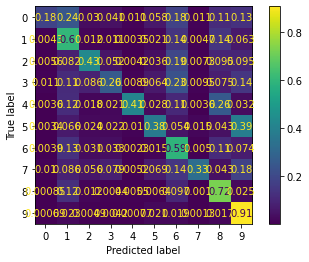

In [37]:
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(targets_t, preds_t)
confusion_matrix_n = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_n)

cm_display.plot()
plt.show()

In [38]:
model_p2_SGD = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels = 10, output_attentions = False, output_hidden_states = False)

lr = 0.005
epochs = 10


optimizer_SGD = torch.optim.SGD(params = model_p2_SGD.parameters(), lr=lr, momentum = 0.9)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

In [39]:
model_p2_SGD = model_p2_SGD.to(device)
save_path_p2_SGD = "BestModel_P2_SGD.pth"
train(train_dataloader, valid_dataloader, model_p2_SGD, optimizer_SGD, epochs, save_path_p2_SGD)

####  Epoch: 1  ####


  0%|          | 0/4527 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 4527/4527 [04:58<00:00, 15.17it/s]


Train Loss = 0.009560829395605637  Train Accuracy = 0.2844618558883667   Validation Loss = 0.009616636632243634  Validation Accuracy = 0.28077951073646545
####  Epoch: 2  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.17it/s]


Train Loss = 0.009393441214127232  Train Accuracy = 0.31413817405700684   Validation Loss = 0.009446131669705754  Validation Accuracy = 0.3106426000595093
####  Epoch: 3  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.16it/s]


Train Loss = 0.009161357965942876  Train Accuracy = 0.37467125058174133   Validation Loss = 0.009240337621267561  Validation Accuracy = 0.3716528117656708
####  Epoch: 4  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.16it/s]


Train Loss = 0.008913458903933816  Train Accuracy = 0.4148126244544983   Validation Loss = 0.009011943594690208  Validation Accuracy = 0.4113943576812744
####  Epoch: 5  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.15it/s]


Train Loss = 0.00869374010167351  Train Accuracy = 0.43678510189056396   Validation Loss = 0.00880500775881635  Validation Accuracy = 0.4338434636592865
####  Epoch: 6  ####


100%|██████████| 4527/4527 [04:59<00:00, 15.14it/s]


Train Loss = 0.008495313937345617  Train Accuracy = 0.45305564999580383   Validation Loss = 0.008652267893967622  Validation Accuracy = 0.4496862292289734
####  Epoch: 7  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.15it/s]


Train Loss = 0.008292440424901822  Train Accuracy = 0.4657573103904724   Validation Loss = 0.008477519457787028  Validation Accuracy = 0.4601031243801117
####  Epoch: 8  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.16it/s]


Train Loss = 0.008104036431971494  Train Accuracy = 0.47363370656967163   Validation Loss = 0.008325174877036183  Validation Accuracy = 0.46652308106422424
####  Epoch: 9  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.16it/s]


Train Loss = 0.007876291274670565  Train Accuracy = 0.49150577187538147   Validation Loss = 0.008153252712789752  Validation Accuracy = 0.4839397668838501
####  Epoch: 10  ####


100%|██████████| 4527/4527 [04:58<00:00, 15.17it/s]


Train Loss = 0.007707734611082879  Train Accuracy = 0.5038622617721558   Validation Loss = 0.008025365906463277  Validation Accuracy = 0.4975666105747223


In [17]:
Model_p2_SGD = torch.load(save_path_p2_SGD)
preds , targets = test(Model_p2_SGD, test_dataloader)
preds_t = torch.tensor(preds)
targets_t = torch.tensor(targets)

  0%|          | 0/1510 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 1510/1510 [00:35<00:00, 42.60it/s]


Calculation of Accuracy and F1 Score metrics

In [18]:
accuracy = metrics.accuracy_score(targets_t , preds_t)
f1_score_micro = metrics.f1_score(targets_t, preds_t, average='micro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")

Accuracy Score = 0.5148377477272257
F1 Score (Micro) = 0.5148377477272257


Confusion Matrix Plot

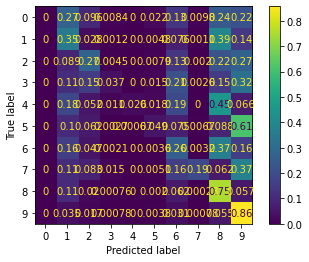

In [19]:
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(targets_t, preds_t)
confusion_matrix_n = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_n)

cm_display.plot()
plt.show()

اپتیمایزر اس جی دی همگرایی ضعیف تری نسبت به آدام در این مسئله از خود نشان داد و به ازای تعداد ایپاک برابر، آدام همگرایی بهتری داشت. علیرغم آن که اس جی دی نیز در تعداد ایپاک بیشتر می توانست به دقت بهتری برسد. اما در مجموع مااتریس در هم ریختگی مربوط به آدام نیز برتری آن را نشان می دهد.

# Perplexity

In [17]:
LOSS_FN = torch.nn.CrossEntropyLoss()
def perplexity_cal(per_data, per_model):
    ids, mask,token_type_ids, labels = per_data
    ids = ids.to(device, dtype = torch.long)
    mask = mask.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.long)
    labels = torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float).reshape((-1,10))
    preds = per_model(ids, attention_mask = mask, labels =labels)[1]
    loss = LOSS_FN(preds, labels).item()
    return torch.exp(torch.tensor(loss))

In [18]:
perplexity_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle = True)
perplexity_data = next(iter(perplexity_dataloader))

model_before_tuning = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels = 10, output_attentions = False, output_hidden_states = False)
model_after_tuning = torch.load(save_path_p2_Adam)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

In [19]:
per_before = perplexity_cal(perplexity_data, model_before_tuning.to(device))
per_after = perplexity_cal(perplexity_data, model_after_tuning.to(device))

print(f"Perplexity Bofore Training = {per_before}")
print(f"Perplexity After Training = {per_after}")

Perplexity Bofore Training = 9.606740951538086
Perplexity After Training = 2.6331326961517334


هر چه معیار پرپلکسیتی به 1 نزدیک تر باشد، یعنی لاس کمتری داشتیم و بنابراین قابل توجه است که پرپلکسیتی با اعمال فاین تیونینگ از حدود 9.6 به 2.6 کاهش یافته است و این بیانگر بهتر شدن وضعیت مدل است.